# Importing libraries

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from collections import Counter
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')

# Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/Self-Driving Car'
IMAGE_PATH = os.path.join(BASE_PATH, 'Images')
LABEL_PATH = os.path.join(BASE_PATH, 'Labels')

# BDD100K Dataset Loader and Parser
This class, BDD100KLoader, is designed to efficiently **load, parse, and flatten** the nested JSON annotation files from the **BDD100K** dataset into a clean, unified **Pandas DataFrame.**

In [ ]:
class BDD100KLoader:
    """
    Optimized loader to parse BDD100K JSON labels into a clean DataFrame
    with parallel processing support for faster loading
    """
    def __init__(self, label_dir, use_parallel=True, max_workers=4):
        """
        Initialize the loader with the directory containing BDD100K label JSON files.

        Args:
            label_dir: Path to labels directory
            use_parallel: Use parallel processing for faster loading
            max_workers: Number of parallel workers
        """
        self.label_dir = label_dir
        self.use_parallel = use_parallel
        self.max_workers = max_workers

        self.raw_data = []
        self.master_df = pd.DataFrame()

        # Target categories for object detection
        self.target_categories = [
            'car', 'person', 'traffic sign', 'bus', 'truck', 'train',
            'rider', 'motor', 'bike', 'traffic light'
        ]

        # BDD100K standard splits
        self.splits = ['train', 'val', 'test']

        # Statistics
        self.stats = {}

    def _load_single_json(self, args):
        """Load a single JSON file (for parallel processing)"""
        file_path, split_name = args

        try:
            with open(file_path, 'r') as f:
                data = json.load(f)

                if isinstance(data, list):
                    return [(entry, split_name) for entry in data]
                elif isinstance(data, dict):
                    return [(data, split_name)]
                else:
                    return []
        except Exception as e:
            print(f"Failed to load {os.path.basename(file_path)}: {e}")
            return []

    def _load_json_data(self):
        """
        Load all BDD100K JSON files from train/val/test subdirectories
        with optional parallel processing
        """
        self.raw_data = []

        for split_name in self.splits:
            split_path = os.path.join(self.label_dir, split_name)

            if not os.path.isdir(split_path):
                print(f"WARNING: Directory {split_path} not found. Skipping {split_name} split.")
                continue

            try:
                json_files = [f for f in os.listdir(split_path) if f.endswith('.json')]
            except OSError as e:
                print(f"Cannot list files in {split_path} (Google Drive I/O issue)")
                print(f"Trying to process anyway...")
                # Try to continue with whatever we can access
                continue

            print(f"Found {len(json_files)} JSON file(s) in '{split_name}' split.")

            # Prepare file paths
            file_args = [(os.path.join(split_path, f), split_name) for f in json_files]

            # Load with or without parallel processing
            if self.use_parallel and len(json_files) > 100:
                print(f"Loading {split_name} with parallel processing...")
                with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                    results = list(tqdm(
                        executor.map(self._load_single_json, file_args),
                        total=len(file_args),
                        desc=f"Loading {split_name}"
                    ))

                # Flatten results
                for result in results:
                    self.raw_data.extend(result)
            else:
                print(f"Loading {split_name} sequentially...")
                for args in tqdm(file_args, desc=f"Loading {split_name}"):
                    result = self._load_single_json(args)
                    self.raw_data.extend(result)

        if not self.raw_data:
            print("ERROR: No annotation data was successfully loaded from any split.")
            return False

        print(f"Total images loaded: {len(self.raw_data)}")
        return True

    def _parse_and_flatten(self):
        """
        Parse the nested JSON structure and flatten it into a DataFrame
        """
        if not self.raw_data:
            print("No raw data loaded. Cannot parse.")
            return

        master_list = []
        print("Parsing JSON data and creating records...")

        for image_entry, split in tqdm(self.raw_data, desc="Parsing"):
            # Image-level attributes
            image_name = image_entry.get('name')
            attributes = image_entry.get('attributes', {})

            weather = attributes.get('weather', 'unknown')
            scene = attributes.get('scene', 'unknown')
            timeofday = attributes.get('timeofday', 'unknown')

            # Extract objects from frames
            frames = image_entry.get('frames', [])

            if not frames:
                continue

            objects = frames[0].get('objects', [])
            has_valid_objects = False

            # Object-level attributes
            for obj in objects:
                category = obj.get('category')
                box2d = obj.get('box2d')

                # Filter for target categories and valid bounding boxes
                if box2d and category in self.target_categories:
                    record = {
                        'image_name': image_name,
                        'split': split,
                        'category': category,
                        'x1': box2d.get('x1'),
                        'y1': box2d.get('y1'),
                        'x2': box2d.get('x2'),
                        'y2': box2d.get('y2'),
                        'weather': weather,
                        'scene': scene,
                        'timeofday': timeofday
                    }
                    master_list.append(record)
                    has_valid_objects = True

            # Keep record for images with no target objects (except test)
            if not has_valid_objects and split != 'test':
                master_list.append({
                    'image_name': image_name,
                    'split': split,
                    'category': 'background',
                    'x1': 0, 'y1': 0, 'x2': 0, 'y2': 0,
                    'weather': weather,
                    'scene': scene,
                    'timeofday': timeofday
                })

        # Create DataFrame
        self.master_df = pd.DataFrame(master_list)

        # Convert bbox coordinates to numeric
        for col in ['x1', 'y1', 'x2', 'y2']:
            self.master_df[col] = pd.to_numeric(self.master_df[col], errors='coerce')

        # Drop invalid coordinates
        self.master_df.dropna(subset=['x1', 'y1', 'x2', 'y2'], inplace=True)

        # Add computed columns
        self.master_df['bbox_width'] = self.master_df['x2'] - self.master_df['x1']
        self.master_df['bbox_height'] = self.master_df['y2'] - self.master_df['y1']
        self.master_df['bbox_area'] = self.master_df['bbox_width'] * self.master_df['bbox_height']

        print("DataFrame creation complete.")

    def get_master_dataframe(self):
        """
        Execute loading and parsing, return the DataFrame
        """
        if self.master_df.empty:
            if self._load_json_data():
                self._parse_and_flatten()

        return self.master_df

    def compute_statistics(self):
        """
        Compute comprehensive statistics about the dataset
        """
        if self.master_df.empty:
            print("No data loaded. Call get_master_dataframe() first.")
            return None

        df = self.master_df

        self.stats = {
            'total_annotations': len(df),
            'unique_images': df['image_name'].nunique(),
            'splits': {},
            'categories': {},
            'environmental_factors': {}
        }

        # Per-split statistics
        for split in df['split'].unique():
            split_df = df[df['split'] == split]
            self.stats['splits'][split] = {
                'num_images': split_df['image_name'].nunique(),
                'num_annotations': len(split_df),
                'avg_objects_per_image': len(split_df) / split_df['image_name'].nunique(),
                'categories': dict(split_df['category'].value_counts())
            }

        # Category statistics
        for cat in df['category'].unique():
            cat_df = df[df['category'] == cat]
            self.stats['categories'][cat] = {
                'count': len(cat_df),
                'avg_bbox_width': cat_df['bbox_width'].mean(),
                'avg_bbox_height': cat_df['bbox_height'].mean(),
                'avg_bbox_area': cat_df['bbox_area'].mean()
            }

        # Environmental factors
        self.stats['environmental_factors'] = {
            'weather': dict(df['weather'].value_counts()),
            'scene': dict(df['scene'].value_counts()),
            'timeofday': dict(df['timeofday'].value_counts())
        }

        return self.stats

    def print_summary(self):
        """
        Print a comprehensive summary of the dataset
        """
        if self.master_df.empty:
            print("No data loaded.")
            return

        if not self.stats:
            self.compute_statistics()

        print("=" * 80)
        print("BDD100K DATASET SUMMARY")
        print("=" * 80)

        print(f"\nOVERALL STATISTICS:")
        print(f"  Total annotations: {self.stats['total_annotations']:,}")
        print(f"  Unique images: {self.stats['unique_images']:,}")

        print(f"\nSPLIT DISTRIBUTION:")
        for split, stats in self.stats['splits'].items():
            print(f"  {split.upper()}:")
            print(f"    - Images: {stats['num_images']:,}")
            print(f"    - Annotations: {stats['num_annotations']:,}")
            print(f"    - Avg objects/image: {stats['avg_objects_per_image']:.2f}")

        print(f"\nCATEGORY DISTRIBUTION:")
        sorted_cats = sorted(self.stats['categories'].items(),
                           key=lambda x: x[1]['count'], reverse=True)
        for cat, stats in sorted_cats[:10]:
            print(f"  {cat:20s}: {stats['count']:>7,} annotations")

        print(f"\nENVIRONMENTAL FACTORS:")
        print(f"  Weather: {dict(list(self.stats['environmental_factors']['weather'].items())[:5])}\n")
        print(f"  Scene: {dict(list(self.stats['environmental_factors']['scene'].items())[:5])}\n")
        print(f"  Time of Day: {self.stats['environmental_factors']['timeofday']}")

        print("=" * 80)

In [ ]:
print("Loading BDD100K dataset...")
loader = BDD100KLoader(label_dir=LABEL_PATH, use_parallel=True, max_workers=4)
master_df = loader.get_master_dataframe()

Loading BDD100K dataset...
Found 70000 JSON file(s) in 'train' split.
Loading train with parallel processing...


Loading train:   0%|          | 0/70000 [00:00<?, ?it/s]

Found 10000 JSON file(s) in 'val' split.
Loading val with parallel processing...


Loading val:   0%|          | 0/10000 [00:00<?, ?it/s]

Found 20000 JSON file(s) in 'test' split.
Loading test with parallel processing...


Loading test:   0%|          | 0/20000 [00:00<?, ?it/s]

Total images loaded: 100000
Parsing JSON data and creating records...


Parsing:   0%|          | 0/100000 [00:00<?, ?it/s]

DataFrame creation complete.


In [ ]:
loader.print_summary()

BDD100K DATASET SUMMARY

OVERALL STATISTICS:
  Total annotations: 1,841,711
  Unique images: 100,000

SPLIT DISTRIBUTION:
  TRAIN:
    - Images: 70,000
    - Annotations: 1,288,405
    - Avg objects/image: 18.41
  VAL:
    - Images: 10,000
    - Annotations: 185,578
    - Avg objects/image: 18.56
  TEST:
    - Images: 20,000
    - Annotations: 367,728
    - Avg objects/image: 18.39

CATEGORY DISTRIBUTION:
  car                 : 1,021,811 annotations
  traffic sign        : 343,882 annotations
  traffic light       : 266,032 annotations
  person              : 129,350 annotations
  truck               :  42,963 annotations
  bus                 :  16,502 annotations
  bike                :  10,232 annotations
  rider               :   6,465 annotations
  motor               :   4,295 annotations
  train               :     179 annotations

ENVIRONMENTAL FACTORS:
  Weather: {'clear': np.int64(935373), 'overcast': np.int64(265059), 'undefined': np.int64(231403), 'snowy': np.int64(142229)

In [ ]:
master_df.head(10)

,image_name,split,category,x1,y1,x2,y2,weather,scene,timeofday,bbox_width,bbox_height,bbox_area
0,b001a7ce-36f3fff2,train,car,291.681792,285.152310,390.681780,353.777302,rainy,city street,daytime,98.999988,68.624992,6793.873385
1,b001a7ce-36f3fff2,train,car,234.306798,295.277306,325.431787,366.152297,rainy,city street,daytime,91.124989,70.874991,6458.482775
2,b001a7ce-36f3fff2,train,car,90.306816,279.527310,254.556797,381.902297,rainy,city street,daytime,164.249981,102.374987,16815.089670
3,b001a7ce-36f3fff2,train,car,0.306828,264.902311,152.181810,420.152292,rainy,city street,daytime,151.874982,155.249981,23578.588070
4,b001a7ce-36f3fff2,train,car,364.806782,221.027316,934.056710,519.152278,rainy,city street,daytime,569.249928,298.124962,169707.613154
5,b001a7ce-36f3fff2,train,truck,313.186265,19.964065,602.665203,296.965462,rainy,city street,daytime,289.478938,277.001397,80186.070228
6,afa0000b-64f5485c,train,car,315.769113,381.857441,343.740360,406.332281,clear,highway,daytime,27.971247,24.474840,684.591795
7,afa0000b-64f5485c,train,car,291.294273,376.612833,319.265520,402.835875,clear,highway,daytime,27.971247,26.223042,733.491185
8,afa0000b-64f5485c,train,car,244.092796,376.612833,286.049664,408.080484,clear,highway,daytime,41.956868,31.467651,1320.284079
9,afa0000b-64f5485c,train,car,168.920072,374.864630,244.092795,420.317903,clear,highway,daytime,75.172723,45.453273,3416.846301


In [ ]:
master_df.to_csv(os.path.join(BASE_PATH, 'master_df.csv'), index=False)

In [ ]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1841711 entries, 0 to 1841710
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   image_name   object 
 1   split        object 
 2   category     object 
 3   x1           float64
 4   y1           float64
 5   x2           float64
 6   y2           float64
 7   weather      object 
 8   scene        object 
 9   timeofday    object 
 10  bbox_width   float64
 11  bbox_height  float64
 12  bbox_area    float64
dtypes: float64(7), object(6)
memory usage: 182.7+ MB


# Exploratory Data Analysis (EDA)

In [ ]:
def plot_category_distribution(figsize=(18, 7), df=master_df):
    """Plot object category distribution across splits"""
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    palette = sns.color_palette("viridis", 10)

    for idx, split in enumerate(['train', 'val', 'test']):
        split_df = df[df['split'] == split]

        if len(split_df) == 0:
            continue

        cat_counts = split_df['category'].value_counts().head(10)

        axes[idx].barh(range(len(cat_counts)), cat_counts.values, color=palette[:len(cat_counts)])
        axes[idx].set_yticks(range(len(cat_counts)))
        axes[idx].set_yticklabels(cat_counts.index)
        axes[idx].set_xlabel('Count')
        axes[idx].set_title(f'{split.upper()} Split - Top 10 Categories')
        axes[idx].invert_yaxis()

    plt.tight_layout()
    plt.show()

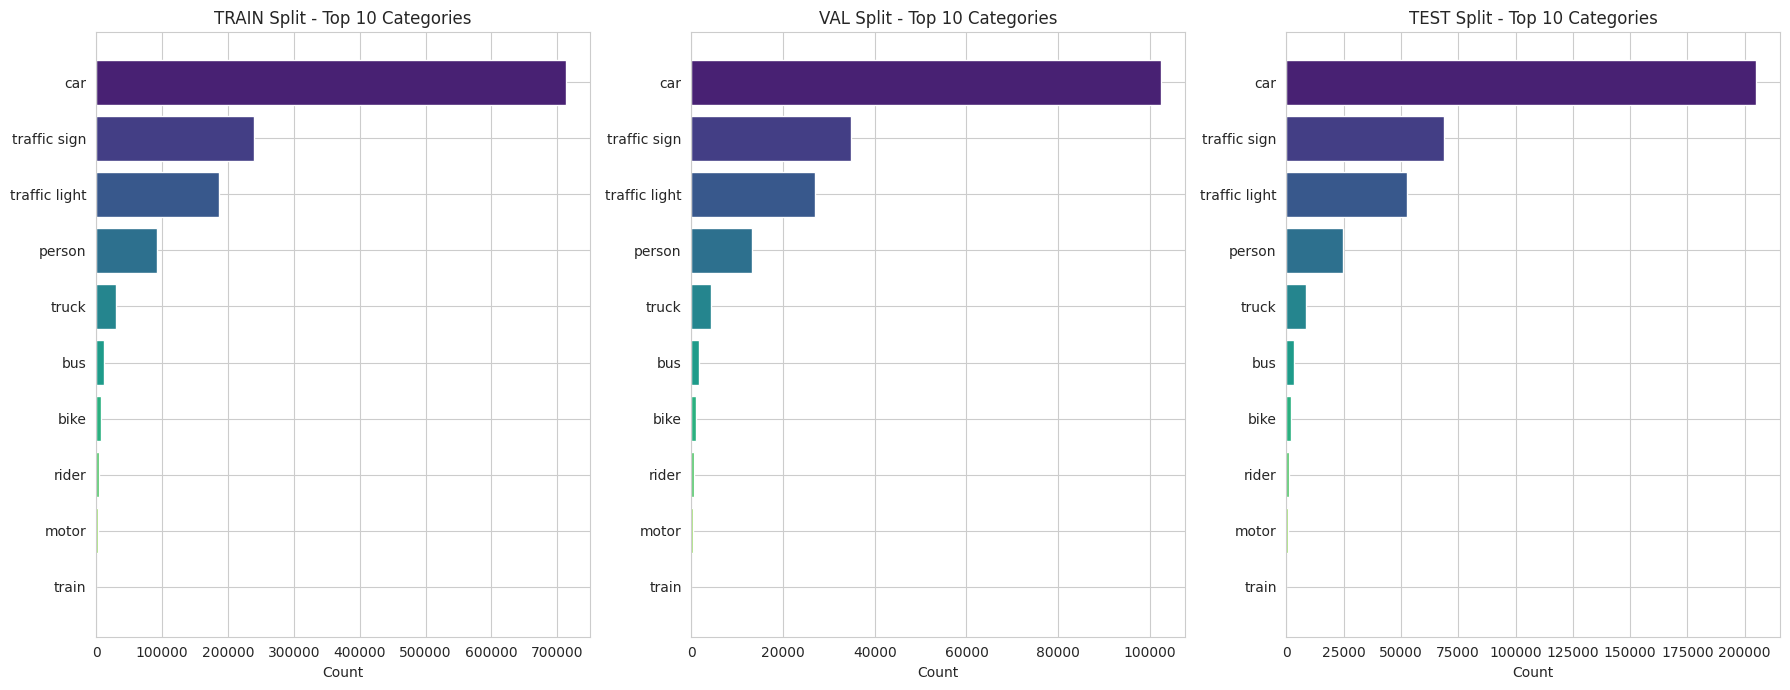

In [ ]:
plot_category_distribution()

In [ ]:
def print_category_counts_per_split(df):
    """
    Calculates and prints the count of every object category
    for the 'train', 'val', and 'test' splits.
    """
    if df.empty:
        print("ERROR: DataFrame is empty. Load data using get_master_dataframe() first.")
        return

    print("--- Object Category Counts by Dataset Split ---")

    for split in ['train', 'val', 'test']:
        split_df = df[df['split'] == split]

        if len(split_df) == 0:
            print(f"\n{split.upper()} Split: No annotations found.")
            continue

        # Calculate the value counts for the 'category' column
        cat_counts = split_df['category'].value_counts()

        print(f"\n==============================================")
        print(f"| {split.upper()} Split (Total Annotations: {len(split_df):,})")
        print(f"==============================================")

        # Format and print the counts
        for category, count in cat_counts.items():
            print(f"| {category:<15}: {count:,}")

    print("\n----------------------------------------------")

# Example Usage:
print_category_counts_per_split(master_df)

--- Object Category Counts by Dataset Split ---

| TRAIN Split (Total Annotations: 1,288,405)
| car            : 714,121
| traffic sign   : 239,961
| traffic light  : 186,301
| person         : 91,435
| truck          : 30,012
| bus            : 11,688
| bike           : 7,227
| rider          : 4,522
| motor          : 3,002
| train          : 136

| VAL Split (Total Annotations: 185,578)
| car            : 102,540
| traffic sign   : 34,915
| traffic light  : 26,891
| person         : 13,265
| truck          : 4,247
| bus            : 1,597
| bike           : 1,007
| rider          : 649
| motor          : 452
| train          : 15

| TEST Split (Total Annotations: 367,728)
| car            : 205,150
| traffic sign   : 69,006
| traffic light  : 52,840
| person         : 24,650
| truck          : 8,704
| bus            : 3,217
| bike           : 1,998
| rider          : 1,294
| motor          : 841
| train          : 28

----------------------------------------------


## Key Dataset Insights
### 1. Dominant Categories (High Imbalance)
The dataset exhibits a significant class imbalance, which is typical for real-world driving data.

* **Top 3 Categories:** The vast majority of annotations belong to three main categories: `car`, `traffic sign`, and `traffic light`.

    * `Car` is the overwhelmingly dominant object, accounting for approximately **55%** to **57%** of the total annotations in every split.

    * In the **TRAIN** split, `car` has over 714K annotations, compared to the fourth-most frequent object, `person`, which has only 91K.

* **Minority Categories:** Objects like `train`, `motor`, `rider`, and `bike` are present in very small numbers (e.g., `train` has only 136 instances in the huge train set), making them **challenging for detection models** due to insufficient training examples.

---

### 2. Consistency Across Splits (Good Splitting)
The most crucial insight is the consistent distribution of categories across the 'train', 'val', and 'test' splits.

* **Proportional Representation:** The top 10 categories maintain the exact **same rank order** in all three splits.

* **Ratio Maintenance:** The ratio of annotations between splits is also highly consistent, which suggests the data was **well-stratified** (i.e., randomly sampled to maintain class proportions).

  * The split ratios are approximately:
    * **Train:** ≈73.7% (1.288M)
    * **Val:** ≈10.6% (185K)
    * **Test:** ≈15.7% (367K)
* This consistency ensures that the validation and test sets are representative of the training data, leading to reliable performance evaluations.

---

### 3. Practical Implications for Model Training

| **Category**        | **Implication / Action-Strategy** |
|----------------------|-----------------------------------|
| **High Imbalance**   | Use techniques like **class-aware sampling**, **weighted loss functions**, or **data augmentation** specifically for low-count classes (*train*, *motor*, *rider*). |
| **Dominant Classes** | Model performance on **car**, **traffic sign**, and **traffic light** should be expected to be high. Evaluation metrics like **mAP (Mean Average Precision)** will be heavily influenced by these objects. |
---

In [ ]:
def plot_category_spatial_distribution(df=master_df, categories=None, max_width=1280, max_height=720):
    """
    Calculates and plots the center point of bounding boxes for each object category
    in a grid format to visualize category-specific spatial bias.

    Args:
        df (pd.DataFrame): The master BDD100K DataFrame.
        categories (list, optional): List of categories to plot. Defaults to top 10.
        max_width (int): Standard image width (BDD100K is 1280).
        max_height (int): Standard image height (BDD100K is 720).
    """
    if df.empty:
        print("ERROR: DataFrame is empty. Load data first.")
        return

    # 1. Prepare Data
    # Calculate Center Coordinates (if not already present)
    df['center_x'] = (df['x1'] + df['x2']) / 2
    df['center_y'] = (df['y1'] + df['y2']) / 2

    # Exclude 'background' and handle NaNs/invalid coords
    plot_df = df[df['category'] != 'background'].dropna(subset=['center_x', 'center_y'])

    # Determine which categories to plot (default to top 10)
    if categories is None:
        categories = plot_df['category'].value_counts().nlargest(10).index.tolist()

    # Filter the DataFrame to include only the categories we are plotting
    plot_df = plot_df[plot_df['category'].isin(categories)]

    # 2. Setup Subplots
    num_cats = len(categories)
    # Arrange plots in a grid (e.g., 2 rows x 5 columns for 10 categories)
    cols = min(5, num_cats)
    rows = int(np.ceil(num_cats / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten() # Flatten the array for easy iteration

    fig.suptitle(f'Spatial Distribution by Category (Center Points)', fontsize=16, y=1.02)

    # 3. Plotting Loop
    for i, cat in enumerate(categories):
        cat_df = plot_df[plot_df['category'] == cat]

        # Plot the scatter points
        axes[i].scatter(
            cat_df['center_x'],
            cat_df['center_y'],
            s=0.5,           # Small size
            alpha=0.3,       # Transparency based on density
            color=plt.cm.tab10(i % 10) # Assign a unique color
        )

        # Invert Y-axis to match image viewing convention (y=0 is top)
        axes[i].invert_yaxis()

        axes[i].set_title(f'{cat.title()} (N={len(cat_df):,})', fontsize=10)
        axes[i].set_xlim(0, max_width)
        axes[i].set_ylim(max_height, 0)
        axes[i].set_xticks([]) # Remove ticks for cleaner look
        axes[i].set_yticks([])
        axes[i].set_aspect('equal', adjustable='box') # Keep the image aspect ratio

    # Remove any unused subplots
    for j in range(num_cats, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 1.01]) # Adjust layout for the suptitle
    plt.show()

    # Drop the temporary columns to keep the master_df clean
    df.drop(columns=['center_x', 'center_y'], inplace=True)

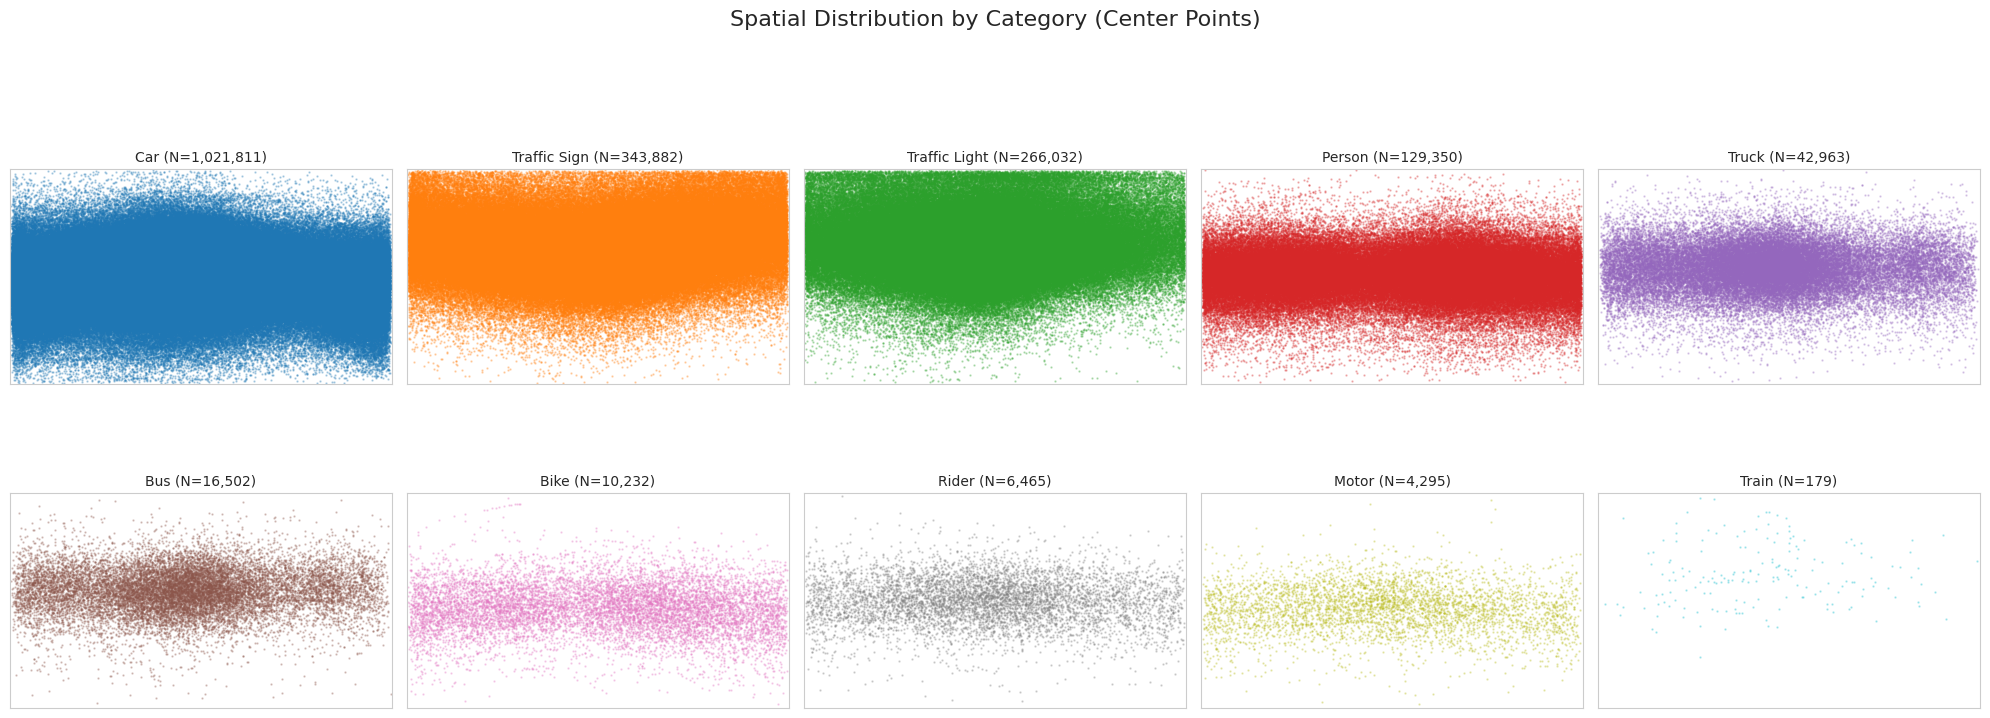

In [ ]:
plot_category_spatial_distribution()

## Key Insights from Spatial Distribution Plots

### 1. Universal Vertical Bias

Across all categories, the points are heavily clustered horizontally and exhibit a **pronounced vertical limitation**.

- **Top/Bottom Blank Space:** There are large, empty gaps at the very top and bottom of every plot.  
- **Top Gap:** Expected, as autonomous vehicle cameras typically don’t point high enough to capture the sky (or the data is cropped), and objects rarely appear at extreme heights.  
- **Bottom Gap:** Likely corresponds to the vehicle’s hood or dashboard, which is often visible and masked out during data preprocessing.  
- **Vertical Centering:** Most objects are concentrated within the **central ≈70%** of the image height.

---

### 2. Category-Specific Biases

The plots reveal **distinct spatial patterns** based on object type, which directly impact model performance.

| **Category** | **Spatial Pattern** | **Implication for Model** |
|---------------|---------------------|----------------------------|
| **Traffic Light** | **Highest Concentration:** The green plot is narrow and positioned relatively high in the image, forming a distinct horizontal band. | The model can be spatially constrained to look for traffic lights only in the **upper-middle region**, improving detection speed. |
| **Traffic Sign** | **Mid-to-High Concentration:** Similar to traffic lights, but slightly wider vertically and extending a bit lower, reflecting their mounting heights. | Detection should focus on the **upper half** of the image. |
| **Car, Truck, Bus** | **Wide, Dense, and Horizontally-Centric:** These categories (especially *Car*) cover the widest area, particularly the central horizontal band, with high density in the **mid-lower** section corresponding to nearby vehicles. | These objects offer the **most balanced training distribution** but remain vertically constrained. |
| **Person, Rider, Bike** | **Wider Vertical Spread, Lower Concentration:** These human-related categories show a broader vertical spread, extending lower but not reaching the extreme bottom—representing sidewalks and road edges. | The model must search a **broader vertical area** for human targets compared to signs. |
| **Train** | **Extremely Sparse:** The *Train* plot is nearly empty (N=179). The few points that exist are scattered with no clear pattern. | Detection will be **difficult** due to both low count and lack of spatial consistency. |

---

### 3. Horizontal and Depth Perception

- **Horizontal Uniformity:** For major categories (*Car*, *Traffic Sign*), the distribution is largely **uniform across the X-axis**, indicating that objects can appear anywhere across the road.  
- **Density Gradient:** A higher density of points toward the **vertical center** (and slightly lower in the frame) suggests that closer objects — which occupy more frame space — bias the plots toward the middle.

---

In [ ]:
def plot_environmental_factors(figsize=(15, 5), df=master_df):
    """Plot environmental factors distribution with colored bars"""
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    palettes = {
        "weather": sns.color_palette("coolwarm", 10),
        "scene": sns.color_palette("Set2", 10),
        "timeofday": sns.color_palette("viridis", 10)
    }

    # --- Weather ---
    weather_counts = df['weather'].value_counts()
    axes[0].bar(
        range(len(weather_counts)),
        weather_counts.values,
        color=palettes["weather"][:len(weather_counts)]
    )
    axes[0].set_xticks(range(len(weather_counts)))
    axes[0].set_xticklabels(weather_counts.index, rotation=45, ha='right')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Weather Distribution')

    # --- Scene ---
    scene_counts = df['scene'].value_counts()
    axes[1].bar(
        range(len(scene_counts)),
        scene_counts.values,
        color=palettes["scene"][:len(scene_counts)]
    )
    axes[1].set_xticks(range(len(scene_counts)))
    axes[1].set_xticklabels(scene_counts.index, rotation=45, ha='right')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Scene Distribution')

    # --- Time of Day ---
    time_counts = df['timeofday'].value_counts()
    axes[2].bar(
        range(len(time_counts)),
        time_counts.values,
        color=palettes["timeofday"][:len(time_counts)]
    )
    axes[2].set_xticks(range(len(time_counts)))
    axes[2].set_xticklabels(time_counts.index, rotation=45, ha='right')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Time of Day Distribution')

    plt.tight_layout()
    plt.show()

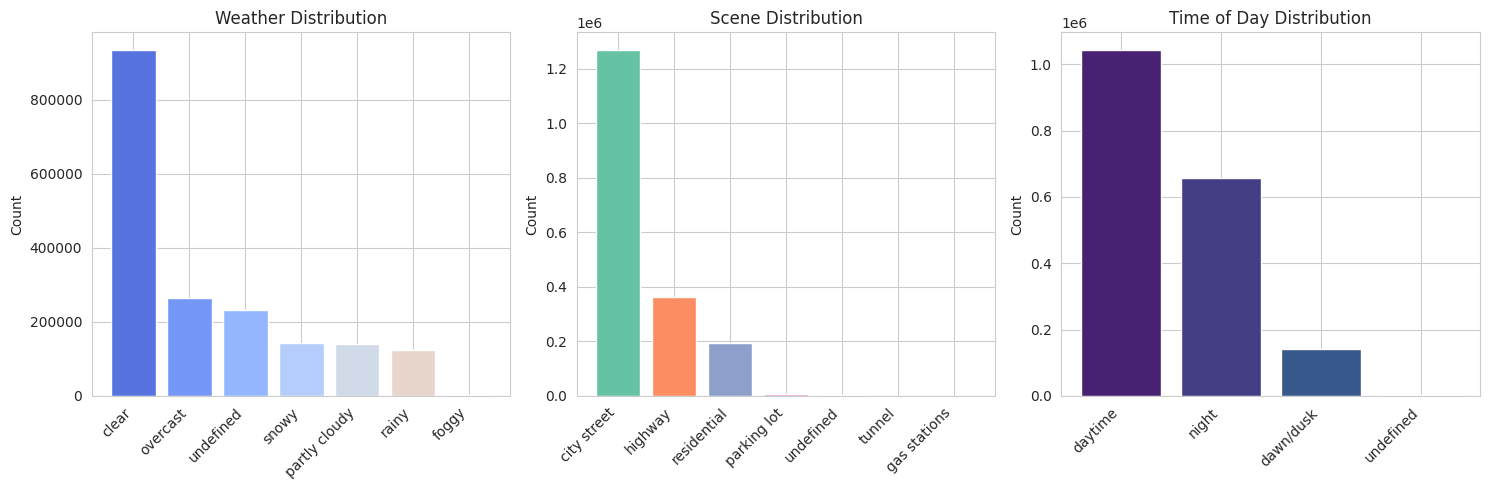

In [ ]:
plot_environmental_factors()

In [ ]:
def print_total_environmental_counts(df):
    """
    Calculates and prints the total count of environmental attributes
    ('weather', 'timeofday', 'scene') across the entire dataset (all splits combined).
    """
    if df.empty:
        print("ERROR: DataFrame is empty. Load data using get_master_dataframe() first.")
        return

    # Attributes to analyze based on project requirements
    attributes = ['weather', 'timeofday', 'scene']
    total_annotations = len(df)

    print("--- Total Environmental Attribute Counts (All Data) ---")
    print(f"==============================================")
    print(f"| TOTAL DATASET (Total Annotations: {total_annotations:,})")
    print(f"==============================================")

    # Loop through each environmental attribute
    for attribute in attributes:
        # Calculate the value counts for the entire DataFrame column
        attr_counts = df[attribute].value_counts()

        print(f"\n-- {attribute.upper()} --")

        # Format and print the counts
        for value, count in attr_counts.items():
            # Print each attribute value and its corresponding count
            # Also calculate and print the percentage for better insight
            percentage = (count / total_annotations) * 100
            print(f"| {value:<15}: {count:,} ({percentage:.2f}%)")

    print("\n----------------------------------------------")

In [ ]:
print_total_environmental_counts(master_df)

--- Total Environmental Attribute Counts (All Data) ---
| TOTAL DATASET (Total Annotations: 1,841,711)

-- WEATHER --
| clear          : 935,373 (50.79%)
| overcast       : 265,059 (14.39%)
| undefined      : 231,403 (12.56%)
| snowy          : 142,229 (7.72%)
| partly cloudy  : 140,000 (7.60%)
| rainy          : 125,018 (6.79%)
| foggy          : 2,629 (0.14%)

-- TIMEOFDAY --
| daytime        : 1,043,700 (56.67%)
| night          : 655,642 (35.60%)
| dawn/dusk      : 140,733 (7.64%)
| undefined      : 1,636 (0.09%)

-- SCENE --
| city street    : 1,269,705 (68.94%)
| highway        : 364,018 (19.77%)
| residential    : 193,177 (10.49%)
| parking lot    : 7,923 (0.43%)
| undefined      : 5,076 (0.28%)
| tunnel         : 1,375 (0.07%)
| gas stations   : 437 (0.02%)

----------------------------------------------


## Key Insights from Environmental Attribute
### 1. Weather Distribution (Focus on Ideal vs. Adverse Conditions)
The dataset is heavily skewed towards ideal driving weather, which poses a risk for real-world deployment.

* **Dominance of Clear Weather:** `Clear` weather accounts for over half of all annotations (**50.79%**). Even when adding `overcast` and `partly cloudy`, over **72%** of the data represents relatively benign weather conditions.

* **Adverse Conditions are Minority:** Adverse weather (like `snowy`, `rainy`, and `foggy`) represents a significant minority of the data.
    * `Rainy` (6.79%) and `snowy` (7.72%) are underrepresented.
    * `Foggy` is severely underrepresented at only 0.14% (2,629 annotations).

* **Implication for Model:** A model trained on this data is expected to perform **very well in clear conditions** but may demonstrate **poor and unreliable performance** in foggy environments due to the extreme lack of training examples.

---

### 2. Time of Day Distribution (Day vs. Night Balance)
The dataset offers a solid baseline for both daylight and night driving, but the majority is still daylight.

* **Daylight Dominance:** `Daytime` accounts for the majority of annotations (**56.67%**).
* **Good Night Coverage:** `Night` driving is well-represented, making up **35.60%** of the data. This high coverage is beneficial, as it suggests the model should be reasonably robust in **low-light conditions.**
* **Transitional Period:** The `dawn/dusk` transitional period is present at a moderate *7.64%.*

---

### 3. Scene Distribution (Road Type Bias)
The data strongly favors urban driving environments over highway or specialized areas.
* **Urban Focus:** `City street` is the overwhelmingly dominant scene, accounting for nearly **70% (68.94%)** of all annotations.
* **Highway Coverage:** `Highway` driving is the second most common but is far behind (**19.77%**).
* **Rare Scenes:** Scenes `like parking lot`, `tunnel`, and `gas` stations are extremely rare (all under 0.5%).
* **Implication for Model:** The model will be highly specialized for **urban detection tasks.** Performance is likely to degrade in complex, less common scenes like tunnels or parking lots.
---

In [ ]:
def plot_bbox_area_distribution(df):
    """
    Plots the distribution of bounding box area (log scale) to assess the scale
    variation and check for anomalies across the entire dataset.
    """
    if df.empty:
        print("ERROR: DataFrame is empty. Load data first.")
        return

    # Filter out 'background' and invalid boxes
    plot_df = df[(df['category'] != 'background') & (df['bbox_area'] > 0)]

    # Use log transformation to visualize the wide range of areas
    # Add a small epsilon to avoid log(0) errors, although area > 0 filters most.
    log_area = np.log10(plot_df['bbox_area'] + 1e-6)

    plt.figure(figsize=(10, 6))

    # Plot a histogram
    plt.hist(log_area, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

    plt.title('Distribution of Bounding Box Area (Log10 Scale)', fontsize=14)
    plt.xlabel('Log10(Bounding Box Area in Pixels)', fontsize=12)
    plt.ylabel('Frequency (Count)', fontsize=12)

    # Set custom tick labels for better interpretation
    # Show what the log value corresponds to in actual area
    log_ticks = [1, 2, 3, 4, 5, 6]
    area_labels = [f'$10^{{{int(t)}}}$' for t in log_ticks]

    plt.xticks(log_ticks, area_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

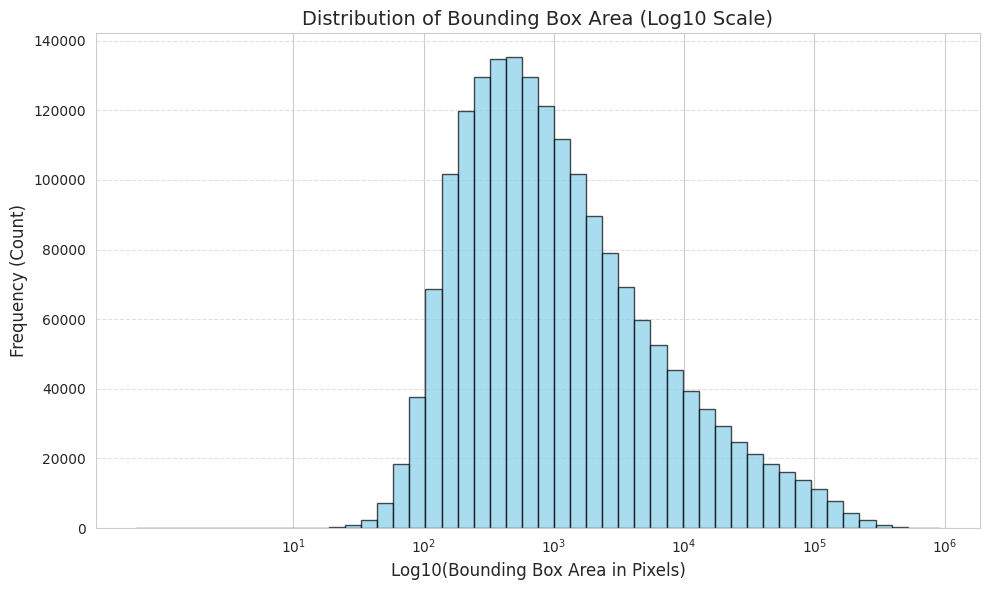

In [ ]:
plot_bbox_area_distribution(master_df)

In [ ]:
def plot_category_size_bias(df, categories=None, top_n=10, figsize=(16, 6)):
    """
    Plots the distribution of bounding box area and aspect ratio for the top categories
    to reveal size and shape biases per class.
    """
    if df.empty:
        print("ERROR: DataFrame is empty. Load data first.")
        return

    # 1. Prepare Data
    plot_df = df[(df['category'] != 'background') & (df['bbox_area'] > 0)]

    # Calculate Aspect Ratio (Ratio of width to height)
    plot_df['aspect_ratio'] = plot_df['bbox_width'] / plot_df['bbox_height']

    # Filter for the top N categories
    if categories is None:
        categories = plot_df['category'].value_counts().nlargest(top_n).index.tolist()

    plot_df = plot_df[plot_df['category'].isin(categories)]

    # Use log transformation for Area, as values span a very large range
    plot_df['log_area'] = np.log10(plot_df['bbox_area'])

    # 2. Setup Subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Category-Specific Bounding Box Size and Shape Bias', fontsize=16, y=1.02)

    # --- PLOT 1: Log Area Distribution ---
    sns.boxplot(
        x='log_area',
        y='category',
        data=plot_df,
        ax=axes[0],
        orient='h',
        palette='viridis'
    )
    axes[0].set_title('Distribution of Bounding Box Area (Log10)', fontsize=12)
    axes[0].set_xlabel('Log10(Area)', fontsize=10)
    axes[0].set_ylabel('Category', fontsize=10)

    # --- PLOT 2: Aspect Ratio Distribution ---
    sns.boxplot(
        x='aspect_ratio',
        y='category',
        data=plot_df,
        ax=axes[1],
        orient='h',
        palette='viridis'
    )
    axes[1].set_title('Distribution of Aspect Ratio (Width / Height)', fontsize=12)
    axes[1].set_xlabel('Aspect Ratio', fontsize=10)
    axes[1].set_ylabel('Category', fontsize=10)

    # Set common limits for Aspect Ratio for better comparison
    axes[1].set_xlim(0, 5) # Cap at 5 for better visualization, as extreme outliers exist

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

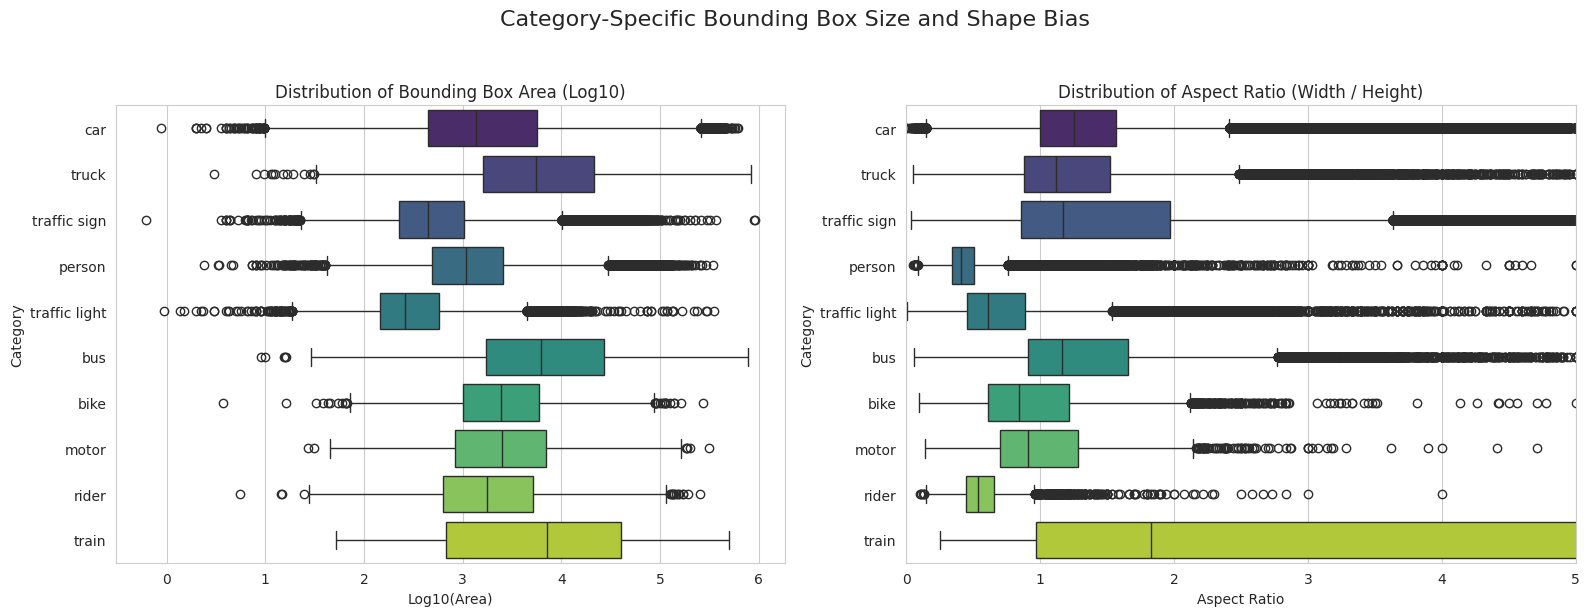

In [ ]:
plot_category_size_bias(master_df)

## Key Insights from Bounding Box Size and Shape Analysis

### 1. Overall Bounding Box Area Distribution (Log Scale)

The histogram of the log-transformed bounding box area reveals the dataset's primary challenge regarding object scale.

- **Small Object Dominance:** The distribution is highly skewed towards the left (smaller areas). The peak frequency occurs around **10³ (1,000 pixels)** or slightly below. This indicates that the dataset is heavily dominated by **small-to-medium sized objects**.  
- **Scale Range:** The area spans a massive range, from tiny objects near **10¹ (10 pixels)** up to large objects nearing **10⁶ (1,000,000 pixels)**.  
- **Implication:** A detection model must be optimized to handle this large variance in scale but should be especially robust at detecting **small objects**, as they represent the majority of the training data.

---

### 2. Category-Specific Bounding Box Area Bias (Log10)

The box plot confirms that the size bias is **not uniform across classes**.

- **Largest Objects:** *Bus* and *Train* have the largest median size (median log area around **4.0–4.5**), reflecting their large real-world size when they appear in the frame.  
- **Smallest Objects (Hardest Targets):** *Traffic light* and *Traffic sign* have the smallest median size (median log area around **2.5–3.0**). These are inherently small objects often seen at a distance, making them the **most challenging objects to detect accurately**.  
- **Vehicles:** General vehicles (*car*, *truck*) show **wide distributions**, covering a large range of sizes, which is expected as they appear both far (small) and close (large).

---

### 3. Aspect Ratio (Shape) Bias

The **aspect ratio (width/height)** is critical for **anchor box design** in models like YOLO or SSD.

#### Wide / Horizontal Objects (Aspect Ratio ≫ 1)
- *Car*, *Truck*, and *Bus* have the **highest median aspect ratios** (around **2.0–2.5**). This confirms they are generally wide and short objects, matching the typical view of a vehicle.  
- *Train* shows the **widest distribution**, meaning its bounding boxes vary dramatically in shape.

#### Tall / Vertical Objects (Aspect Ratio ≈ 1)
- *Person* and *Rider* have the **lowest median aspect ratios** (around **0.5–0.8**), confirming they are generally tall and narrow.  
- *Traffic light* and *Traffic sign* also have relatively low aspect ratios, as they are often detected as **squares or slightly taller rectangles**.

**Implication:** Anchor boxes for the detection model must be specifically designed to cover the **diverse aspect ratios**, utilizing **wide anchors** for vehicles and **tall, narrow anchors** for people and signs.

---

### Conclusion for Data Quality

The data demonstrates **high complexity** due to several factors:

- **Extreme Scale Variance:** The model must handle objects spanning several orders of magnitude in size.  
- **Size Bias:** *Traffic lights* and *traffic signs* are confirmed as the smallest critical objects, representing a key challenge.  
- **Shape Bias:** The distinct aspect ratios between **vehicles (wide)** and **people/signs (tall)** must be accounted for in the model architecture.

---

# Summary of BDD100K Exploratory Data Analysis (EDA)

The EDA revealed critical insights into the dataset's composition, confirming both the project's key challenges and the integrity of the data split.

---

## 1. Annotation and Class Distribution (Count Bias)

The analysis of object counts across the splits confirmed a **severe class imbalance**.

- **Dominant Categories:**  
  The detection task is heavily skewed towards vehicles and static objects. *Car*, *traffic sign*, and *traffic light* account for the vast majority of all annotations in every split.

- **Minority/Rare Classes:**  
  Objects like *train*, *motor*, and *rider* are severely underrepresented, making robust detection for these classes a significant challenge.

- **Split Consistency:**  
  The rank order and proportion of categories are highly consistent across the *train*, *val*, and *test* splits, indicating the dataset was well-stratified and the evaluation is reliable.

---

## 2. Environmental Factor Analysis (Metadata Bias)

The distribution of environmental attributes highlights the need for **Environmental Adaptation**.

- **Time of Day:**  
  The dataset has good coverage for both daytime (≈56.7%) and night (≈35.6%), offering a solid base for low-light adaptation.

- **Weather Bias:**  
  The data is heavily skewed towards ideal conditions — *clear weather dominates (≈50.8%)*.  
  Adverse conditions are severely underrepresented, especially *foggy (≈0.14%)*, suggesting the model may be brittle under these specific conditions.

- **Scene Bias:**  
  The data strongly favors *city street driving (≈68.9%)*, with significantly less representation for *highway (≈19.8%)* and extremely rare scenes like *tunnel* or *parking lot*.

---

## 3. Spatial and Size Analysis (Localization and Scale Bias)

The analysis of bounding box geometry reveals **object placement and scale challenges**.

### Spatial Distribution (Location Bias)

- **Universal Vertical Constraint:**  
  Objects do not appear at the extreme top or bottom of the frame.

- **Category-Specific Placement:**  
  Static objects like *traffic light* and *traffic sign* exhibit a strong bias toward the upper-middle region of the image.  
  *Person* and *rider* have a wider vertical spread but generally stay lower.

**Implication:**  
A strong detector should exploit this vertical constraint for accurate localization.

---

### Bounding Box Size and Shape Bias (Scale Challenge)

- **Scale Dominance:**  
  The overall distribution of bounding box area is heavily skewed towards *small-to-medium sized objects* (area around 10³ pixels), meaning the model must be optimized for detecting distant or small items.

- **Smallest Critical Objects:**  
  *Traffic light* and *traffic sign* have the smallest median size, confirming their status as the most challenging targets for scale invariance.

- **Aspect Ratio:**  
  Categories show distinct shapes:  
  - *Car* and *truck* are generally wide (high aspect ratio).  
  - *Person* and *rider* are tall and narrow (low aspect ratio).  
  This requires the use of **multi-scale, multi-aspect ratio anchor boxes** in the model architecture.

---

## Conclusion for Model Development

The EDA confirms the object detection model must prioritize robustness against three primary forms of bias:

1. **Class Imbalance:**  
   Use weighted loss or sampling.

2. **Environmental Bias:**  
   Ensure robust performance during night and rainy/snowy/foggy conditions.

3. **Scale and Shape Variance:**  
   Optimize the model to handle both the small size of traffic signs and the diverse shapes of all categories.